# Pokémon Keşifsel Veri Analizi ve Sınıflama Modeli

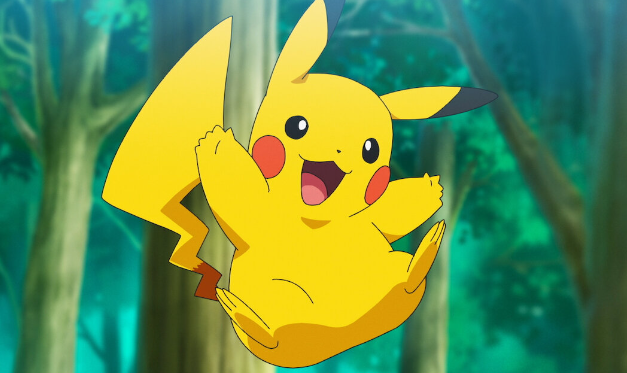

Pokémon veri seti birçok farklı Pokémon türünü; sağlık, saldırı, savunma, hız gibi özelliklerini, jenerasyon bilgilerini ve efsane olup olmadığı bilgilerini içeren bir veri setidir. Veri setine ulaşmak için aşağıda verilen Kaggle bağlantısını takip edebilir ve değişkenler hakkındaki bilgilere aşağıdan ulaşabilirsiniz.

Pokémon Veri Seti: https://www.kaggle.com/datasets/mlomuscio/pokemon

#### Değişkenler
* Num: Her Pokémon için benzersiz kimlik numarası.
* Name: Pokémonların isimleri.
* Type1: Her Pokémon tür bilgisine sahiptir. Bu tür bilgisi Pokémonun saldırılara karşı zayıflık ve direncini belirler.
* Type2: Bazı Pokémonlar ikincil bir tür değerine sahiptir.
* HP: Sağlık Puanı (Health Point), Pokémonun bitkin düşmeden önce ne kadar hasar alabileceğini gösterir.
* Attack: Normal saldırılar (çizik, yumruk vb.) için baz saldırı puanı değeridir.
* Defense: Normal saldırılara karşın baz saldırı direnci değeridir.
* SPAtk: Özel saldırılar (ateş patlaması, kabarcık ışını vb.) için baz saldırı puanı değeridir.
* SPDef: Özel saldırılara karşın baz saldırı direnci değeridir.
* Speed: Hız değeri, her turda hangi Pokémonun önce saldıracağını gösterir.
* Generation: Jenerasyon numarası.
* Legendary: Pokémonun efsanevi olup olmadığının bilgisi (True: Efsanevi, False: Efsanevi Değil)

#### Bonus: Kaggle & GitHub Hesaplarım
Kaggle: https://www.kaggle.com/mybozkir

GitHub: https://github.com/mybozkir

# 1. Kütüphaneler, Veri Seti & Genel Fonksiyonlar

## 1.1. Kütüphanelerin ve Veri Setinin Yüklenmesi

In [75]:
# Genel Kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Sci-kit Model Geliştirme
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline

#Sci-kit Metrikleri
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_score, recall_score, f1_score

#Sci-kit Scaler
from sklearn.preprocessing import StandardScaler


In [76]:
df_ = pd.read_csv(r"C:\Users\myboz\development\datasets\classification\pokemon.csv")
df = df_.copy()

## 1.2. Genel Fonksiyonlar

In [77]:
def variable_analyzer(df, categorical_threshold = 10, cardinal_threshold = 20):
    # Categorical Variables
    categorical = [col for col in df.columns if (df[col].dtypes == "O" and df[col].dtypes == 'C')]
    
    # Numeric & Categorical 
    num_categorical = [col for col in df.columns if (df[col].nunique() < categorical_threshold) and
                       (df[col].dtypes != "O" and df[col].dtypes != "C")]
                                                   
    card_categorical = [col for col in df.columns if (df[col].nunique() > cardinal_threshold) and
                    (df[col].dtypes == "O" and df[col].dtypes == "C")]
                                                   
    categorical_columns_ = categorical + num_categorical
    categorical_columns = [col for col in categorical_columns_ if col not in card_categorical]

    # Numeric
    numeric_columns_ = [col for col in df.columns if (df[col].dtypes != "O" and df[col].dtypes != "C")]
    numeric_columns = [col for col in numeric_columns_ if col not in num_categorical]

    print("\n##################### Categorical #####################")
    print(categorical)
    print("\n##################### Categoric But Cardinal #####################")
    print(card_categorical)
    print("\n##################### Numeric But Categoric #####################")
    print(num_categorical)
    print("\n##################### Numeric #####################")
    print(numeric_columns)

In [78]:
def plot_roc_curve(y_test, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc_score = roc_auc_score(y_test, y_pred_prob)
    
    plt.plot(fpr, tpr, label = 'data 1, AUC= ' + str(auc_score))
    plt.legend(loc=4)
    plt.show()

In [79]:
# Plots Confusion Matrix

def plot_conf_matrix(y_test, predict):
    sns.set(font_scale = 1.1)
    fig, ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(confusion_matrix(y_test, predict),
                     annot = True,
                     cbar = False,
                     fmt='d')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [80]:
def score_me(y_test, predicts):
    print('Accuracy: ', metrics.accuracy_score(y_test, predicts))
    print('Precision: ', metrics.precision_score(y_test, predicts))
    print('Recall: ', metrics.recall_score(y_test, predicts))

# 2. Keşifsel Veri Analizi

## Veri Setine İlk Bakış

info() fonksiyonu ile görebileceğimiz üzere veri seti 800 satır ve 12 sütun içermekte ve 0'dan 799'a kadar olacak şekilde indislenmiş.

'Num' sütununu veri setinden silebiliriz çünkü halihazırda indis değerleri bize ilgili numara değerini sağlamakta.

Kalan 11 sütunun yedisi int64, üçü object ve birisi ise bool veri tipine sahip. Her ne kadar kategorik, yani object veri tipine sahip özellik (feature) sayısı 3 gibi gözükse de, Legendary ve Generation kolonları da büyük ihtimalle kategorik değerleri ifade etmekte ancak sayısal veri tipiyle ifade edilmişler. Bu durumu aklımızda tutarak devam edebiliriz, değişken analizi yaptığımız kısımda tüm özellikleri tekrardan daha detaylıca ele alıyor olacağız.

Son olarak, Type 2 sütununda 414 kayıt olduğunu görüyoruz. Bu durumda veri setinde eksik değer olduğu öne sürülebilir fakat ilgili değişkenin açıklamasında da ifade edildiği gibi, her Pokémon'un ikincil bir türü olmayabilir. Yani bu durumda bu eksiklikler normal olarak kabul edilecektir, Null değerlerin yerine ikincil değerlerin olmadığın ifade eden bir ibare ile doldurma işlemi yapılabilir. Ek olarak, eksik verisi bulunan 386 kaydın silinmesi de veri setinde ciddi bir kayba sebep olacaktır.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Num         800 non-null    int64 
 1   Name        800 non-null    object
 2   Type1       800 non-null    object
 3   Type2       414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   SpAtk       800 non-null    int64 
 8   SpDef       800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


In [82]:
df.isnull().sum()

Num             0
Name            0
Type1           0
Type2         386
HP              0
Attack          0
Defense         0
SpAtk           0
SpDef           0
Speed           0
Generation      0
Legendary       0
dtype: int64

describe() fonksiyonu ile, temel istatistiksel bilgileri görüntüleyebiliriz. Aksini ifade etmediğimiz sürece bu fonksiyon bize (olması gerektiği gibi) sadece numerik değerlerin istatistiksel bilgilerini verir.

* Pokémonların ortalama can değeri (HP) 69.25 gözükmekte. Şaşırtıcı bir şekilde en düşük can değeri 1, bu bir hata mı yoksa değil mi diye bakabiliriz. En yüksek can değeri ise 255 olarak gözüküyor. Lakin Pokémon hakkında ayrıntılı bilgimiz olmadığı için, belki de standart durumda can değerleri 1 ile 255 arasında değişiyor olabilir.

* Ortalama standart saldırı değeri (Attack) 79.00. En düşük saldırı değeri 5 olarak gözükürken en yükseği 190 olarak gözükmekte.

* Standart savunma değerinde ise ortalamada 73.84 değerini görmekteyiz, bu değer ortalama standart saldırı değeri ile çok yakın. Tasarımsal olarak Pokémon evreninde ortalama güç ve direnç dağılımları birbirine yakın denebilir.

* Bir üst maddede ifade edilen durumu destekleyici bir unsur ise, özel saldırı (SpAtk) ve özel savunma (SpDef) değerlerinin de birbirine çok yakın olmasıdır. Maksimum değerler de dengeli bir yapıya sahipken, minimum değerlerde özel savunma değerinde 10 puanlık fazlalık gözüküyor.

* Hız (Speed) değeri için ortalama 68.27, en yavaş Pokémon 5 puanlık hıza sahipken en hızlı Pokémonun değeri 180.

* Jenerasyon (Generation) değeri 1 ile 6 arasında seyrediyor, bu durum bu değerin kategorik olduğunu doğrulamaktadır. Yani şunu da söylemek mümkün, elimizdeki veri setinde 1 ve 6. jenerasyonlar dahil olacak şekilde Pokémonlar bulunmakta.

In [83]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Num,800.0,362.81375,208.343798,1.0,184.75,364.5,539.25,721.0
HP,800.0,69.25875,25.534669,1.0,50.00,65.0,80.00,255.0
Attack,800.0,79.00125,32.457366,5.0,55.00,75.0,100.00,190.0
Defense,800.0,73.84250,31.183501,5.0,50.00,70.0,90.00,230.0
SpAtk,800.0,72.82000,32.722294,10.0,49.75,65.0,95.00,194.0
SpDef,800.0,71.90250,27.828916,20.0,50.00,70.0,90.00,230.0
Speed,800.0,68.27750,29.060474,5.0,45.00,65.0,90.00,180.0
Generation,800.0,3.32375,1.661290,1.0,2.00,3.0,5.00,6.0


## Değişken Analizi

Değişken analizi için yazmış olduğumuz fonksiyon ile, belirlediğimiz eşik değerleri kullanarak elimizdeki kolonların özelliklerini analiz edebiliriz.

Daha önce genel bakışta belirtmiş olduğumuz gibi, Generation ve Legendary kolonları sayısal değere sahip kategorik kolonlardır. Kalan kolonlar ise sayısal değere sahiptir.

In [84]:
variable_analyzer(df)


##################### Categorical #####################
[]

##################### Categoric But Cardinal #####################
[]

##################### Numeric But Categoric #####################
['Generation', 'Legendary']

##################### Numeric #####################
['Num', 'HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']


Önceden belirttiğimiz üzere, Num değişkeni indis değerlerini ifade etmektedir ve veri setinde tutulmasına gerek yoktur. O yüzden bu kolonu veri setinden kaldırıyoruz.

In [85]:
df = df.drop(columns = 'Num')
df.head()

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [86]:
df['Type2'].fillna('None', inplace = True)

C:\Users\myboz\AppData\Local\Temp\ipykernel_34564\2399340910.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Type2'].fillna('None', inplace = True)


In [87]:
df[df['Type2'] == 'None']

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
4,Charmander,Fire,None,39,52,43,60,50,65,1,False
5,Charmeleon,Fire,None,58,64,58,80,65,80,1,False
9,Squirtle,Water,None,44,48,65,50,64,43,1,False
10,Wartortle,Water,None,59,63,80,65,80,58,1,False
11,Blastoise,Water,None,79,83,100,85,105,78,1,False
...,...,...,...,...,...,...,...,...,...,...,...
775,Sliggoo,Dragon,None,68,75,53,83,113,60,6,False
776,Goodra,Dragon,None,90,100,70,110,150,80,6,False
788,Bergmite,Ice,None,55,69,85,32,35,28,6,False
789,Avalugg,Ice,None,95,117,184,44,46,28,6,False


In [88]:
df.isna().sum()

Name          0
Type1         0
Type2         0
HP            0
Attack        0
Defense       0
SpAtk         0
SpDef         0
Speed         0
Generation    0
Legendary     0
dtype: int64

İkincil sınıfı olmayan Pokémonlar için NaN değerlerin yerini None ile doldurmuş olduk. Şimdi son olarak, Generation değişkenindeki sayıları metin bazlı oluşturup veri tipini kategorik hale getireceğiz.

Normal şartlarda, veri seti için herhangi bir makine öğrenmesi modeli kurmak istediğimizde bu kolonu tekrar dummy hale getirmemiz gerekecekti fakat halihazırda Pokémonun kaçıncı jenerasyon olduğunun hedef değişken için bir etkisi olmayacaktır.

In [89]:
generation_map = {
    1: 'First',
    2: 'Second',
    3: 'Third',
    4: 'Fourth',
    5: 'Fifth',
    6: 'Sixth'}

df['Generation'] = df['Generation'].replace(generation_map)

In [90]:
df.Generation.dtypes

dtype('O')

In [91]:
df.head(10)

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,First,False
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,First,False
2,Venusaur,Grass,Poison,80,82,83,100,100,80,First,False
3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,First,False
4,Charmander,Fire,None,39,52,43,60,50,65,First,False
5,Charmeleon,Fire,None,58,64,58,80,65,80,First,False
6,Charizard,Fire,Flying,78,84,78,109,85,100,First,False
7,CharizardMega Charizard X,Fire,Dragon,78,130,111,130,85,100,First,False
8,CharizardMega Charizard Y,Fire,Flying,78,104,78,159,115,100,First,False
9,Squirtle,Water,None,44,48,65,50,64,43,First,False


Artık elimizdeki veri seti Pokémonlara ilişkin anlamlı sonuçlar çıkarmak ve makine öğrenmesi için hazırlanmaya uygun hale geldi.

## Verinin İncelenmesi

Görüldüğü üzere, veri setinde kendini tekrar eden bir veri yok zira veri setinin satır sayısı kadar Pokémon isimlerinde benzersiz isim var.

In [92]:
df.Name.nunique()

800

### Pokémon Türlerinin Dağılımı

Birincil tür bilgisine göre veri setinde en çok su türünde Pokémon bulunmakta. En az ise uçan türde (Flying) bulunuyor.

In [93]:
df['Type1'].value_counts()

Type1
Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: count, dtype: int64

C:\Users\myboz\AppData\Local\Temp\ipykernel_34564\2584660778.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, y = 'Type1', order = df['Type1'].value_counts().index, palette = 'Set1')


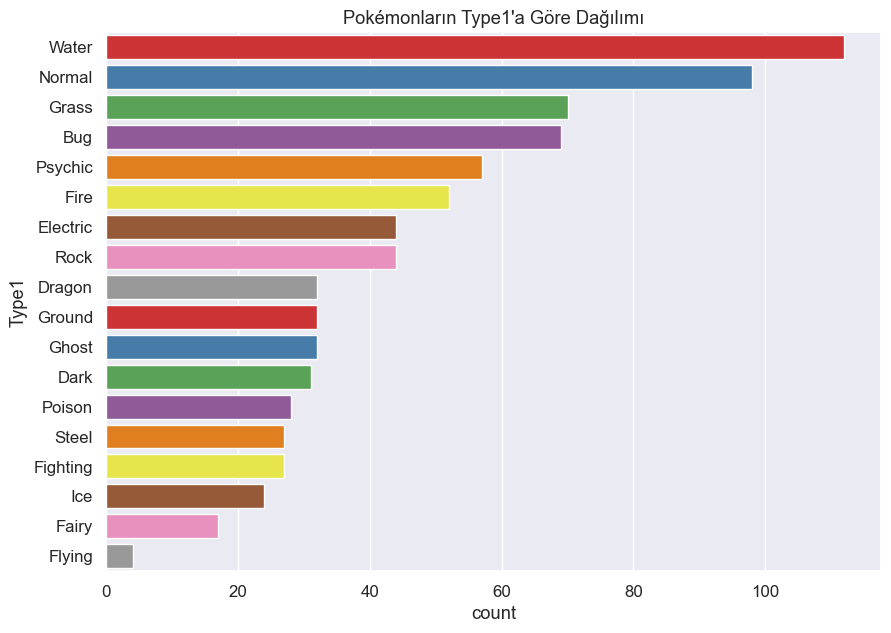

In [94]:
plt.figure(figsize = (10,7))
sns.countplot(data = df, y = 'Type1', order = df['Type1'].value_counts().index, palette = 'Set1')
plt.title("Pokémonların Type1'a Göre Dağılımı")
plt.show()

İkincil tür sayılarına baktığımızda ise None değerinin genel dağılıma göre çokluğu göze çarpıyor. Toplamda 800 Pokémon olduğunu hatırlarsak, bu Pokémonların yarısına yakını sadece tek bir türe ait.

C:\Users\myboz\AppData\Local\Temp\ipykernel_34564\1827157776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = df, y = 'Type2', order = df['Type2'].value_counts().index, palette = 'Set1')


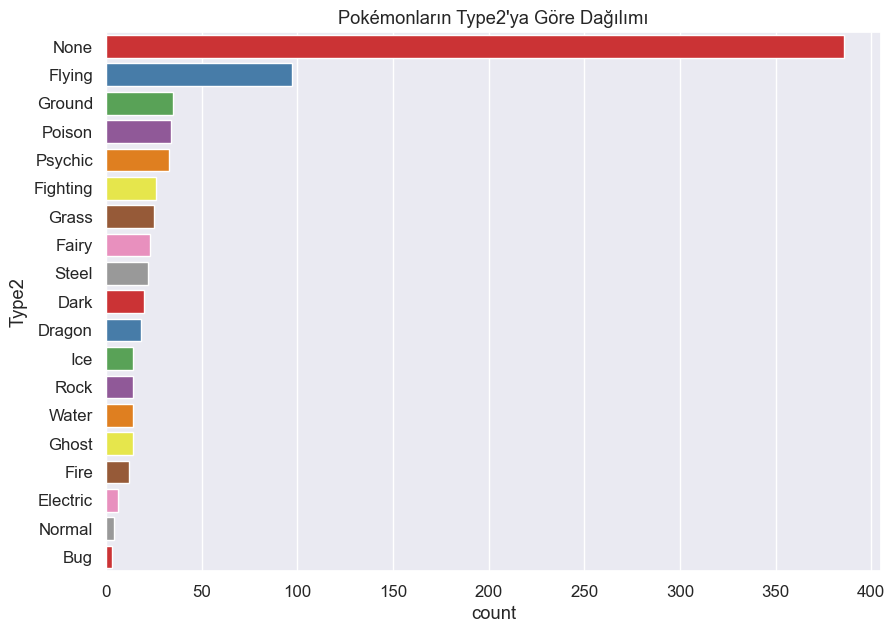

In [95]:
plt.figure(figsize = (10,7))
sns.countplot(data = df, y = 'Type2', order = df['Type2'].value_counts().index, palette = 'Set1')
plt.title("Pokémonların Type2'ya Göre Dağılımı")
plt.show()

Toplamda 414 Pokémon birden fazla türe sahipken, bu durumda 386 Pokémon ise sadece tek bir türe sahiptir. Yani 6 jenerasyonluk Pokémon kaydında Pokémonların çoğunluğu çift türlüdür.

In [96]:
df[df['Type2'] != 'None']['Name'].count()

414

Elimizde birincil ve ikincil türlere ait kırılımlı bilgiler var ancak bir türe ait toplam pokemon sayısını ifade edecek bir bilgimiz yok (unutmayın, bir pokemon birden fazla türe ait olabilir). Bunu bulabilmek için ufak bir fonksiyon yazıp, her tür için toplam pokemon sayısını bulabiliriz.

In [97]:
def count_by_type(type_list, type_):
    type1_count = df[df['Type1'] == type_].shape[0]
    type2_count = df[df['Type2'] == type_].shape[0]
    count_sum = type1_count + type2_count
    
    type_list.append([type_, count_sum])

types = list(df['Type1'].unique())

type_list = []

for type_ in types:
    count_by_type(type_list, type_)

type_count_df = pd.DataFrame(type_list, columns = ['Type', 'Count']).set_index('Type').sort_values(by = 'Count', ascending = False)


Aşağıda görebileceğimiz gibi, elimizdeki veri setinde en çok bulunan pokemon türü su, en az bulunan pokemon türü ise buzdur.

In [98]:
type_count_df

,Count
Type,
Water,126
Normal,102
Flying,101
Grass,95
Psychic,90
Bug,72
Ground,67
Fire,64
Poison,62


<Axes: xlabel='Type'>

<Figure size 700x400 with 0 Axes>

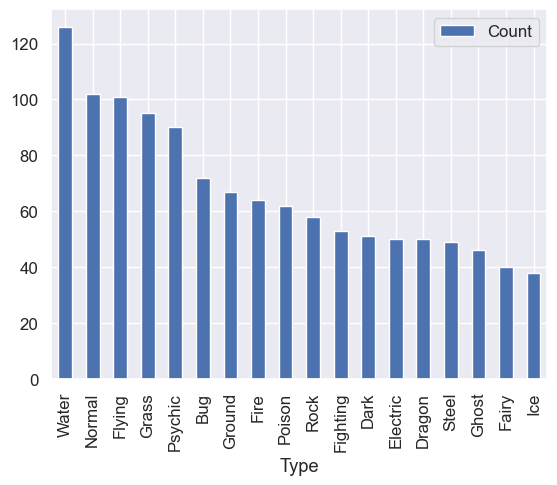

In [99]:
plt.figure(figsize=(7,4))
type_count_df.plot(kind = 'bar')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Grass'),
  Text(1, 0, 'Fire'),
  Text(2, 0, 'Water'),
  Text(3, 0, 'Bug'),
  Text(4, 0, 'Normal'),
  Text(5, 0, 'Poison'),
  Text(6, 0, 'Electric'),
  Text(7, 0, 'Ground'),
  Text(8, 0, 'Fairy'),
  Text(9, 0, 'Fighting'),
  Text(10, 0, 'Psychic'),
  Text(11, 0, 'Rock'),
  Text(12, 0, 'Ghost'),
  Text(13, 0, 'Ice'),
  Text(14, 0, 'Dragon'),
  Text(15, 0, 'Dark'),
  Text(16, 0, 'Steel'),
  Text(17, 0, 'Flying')])

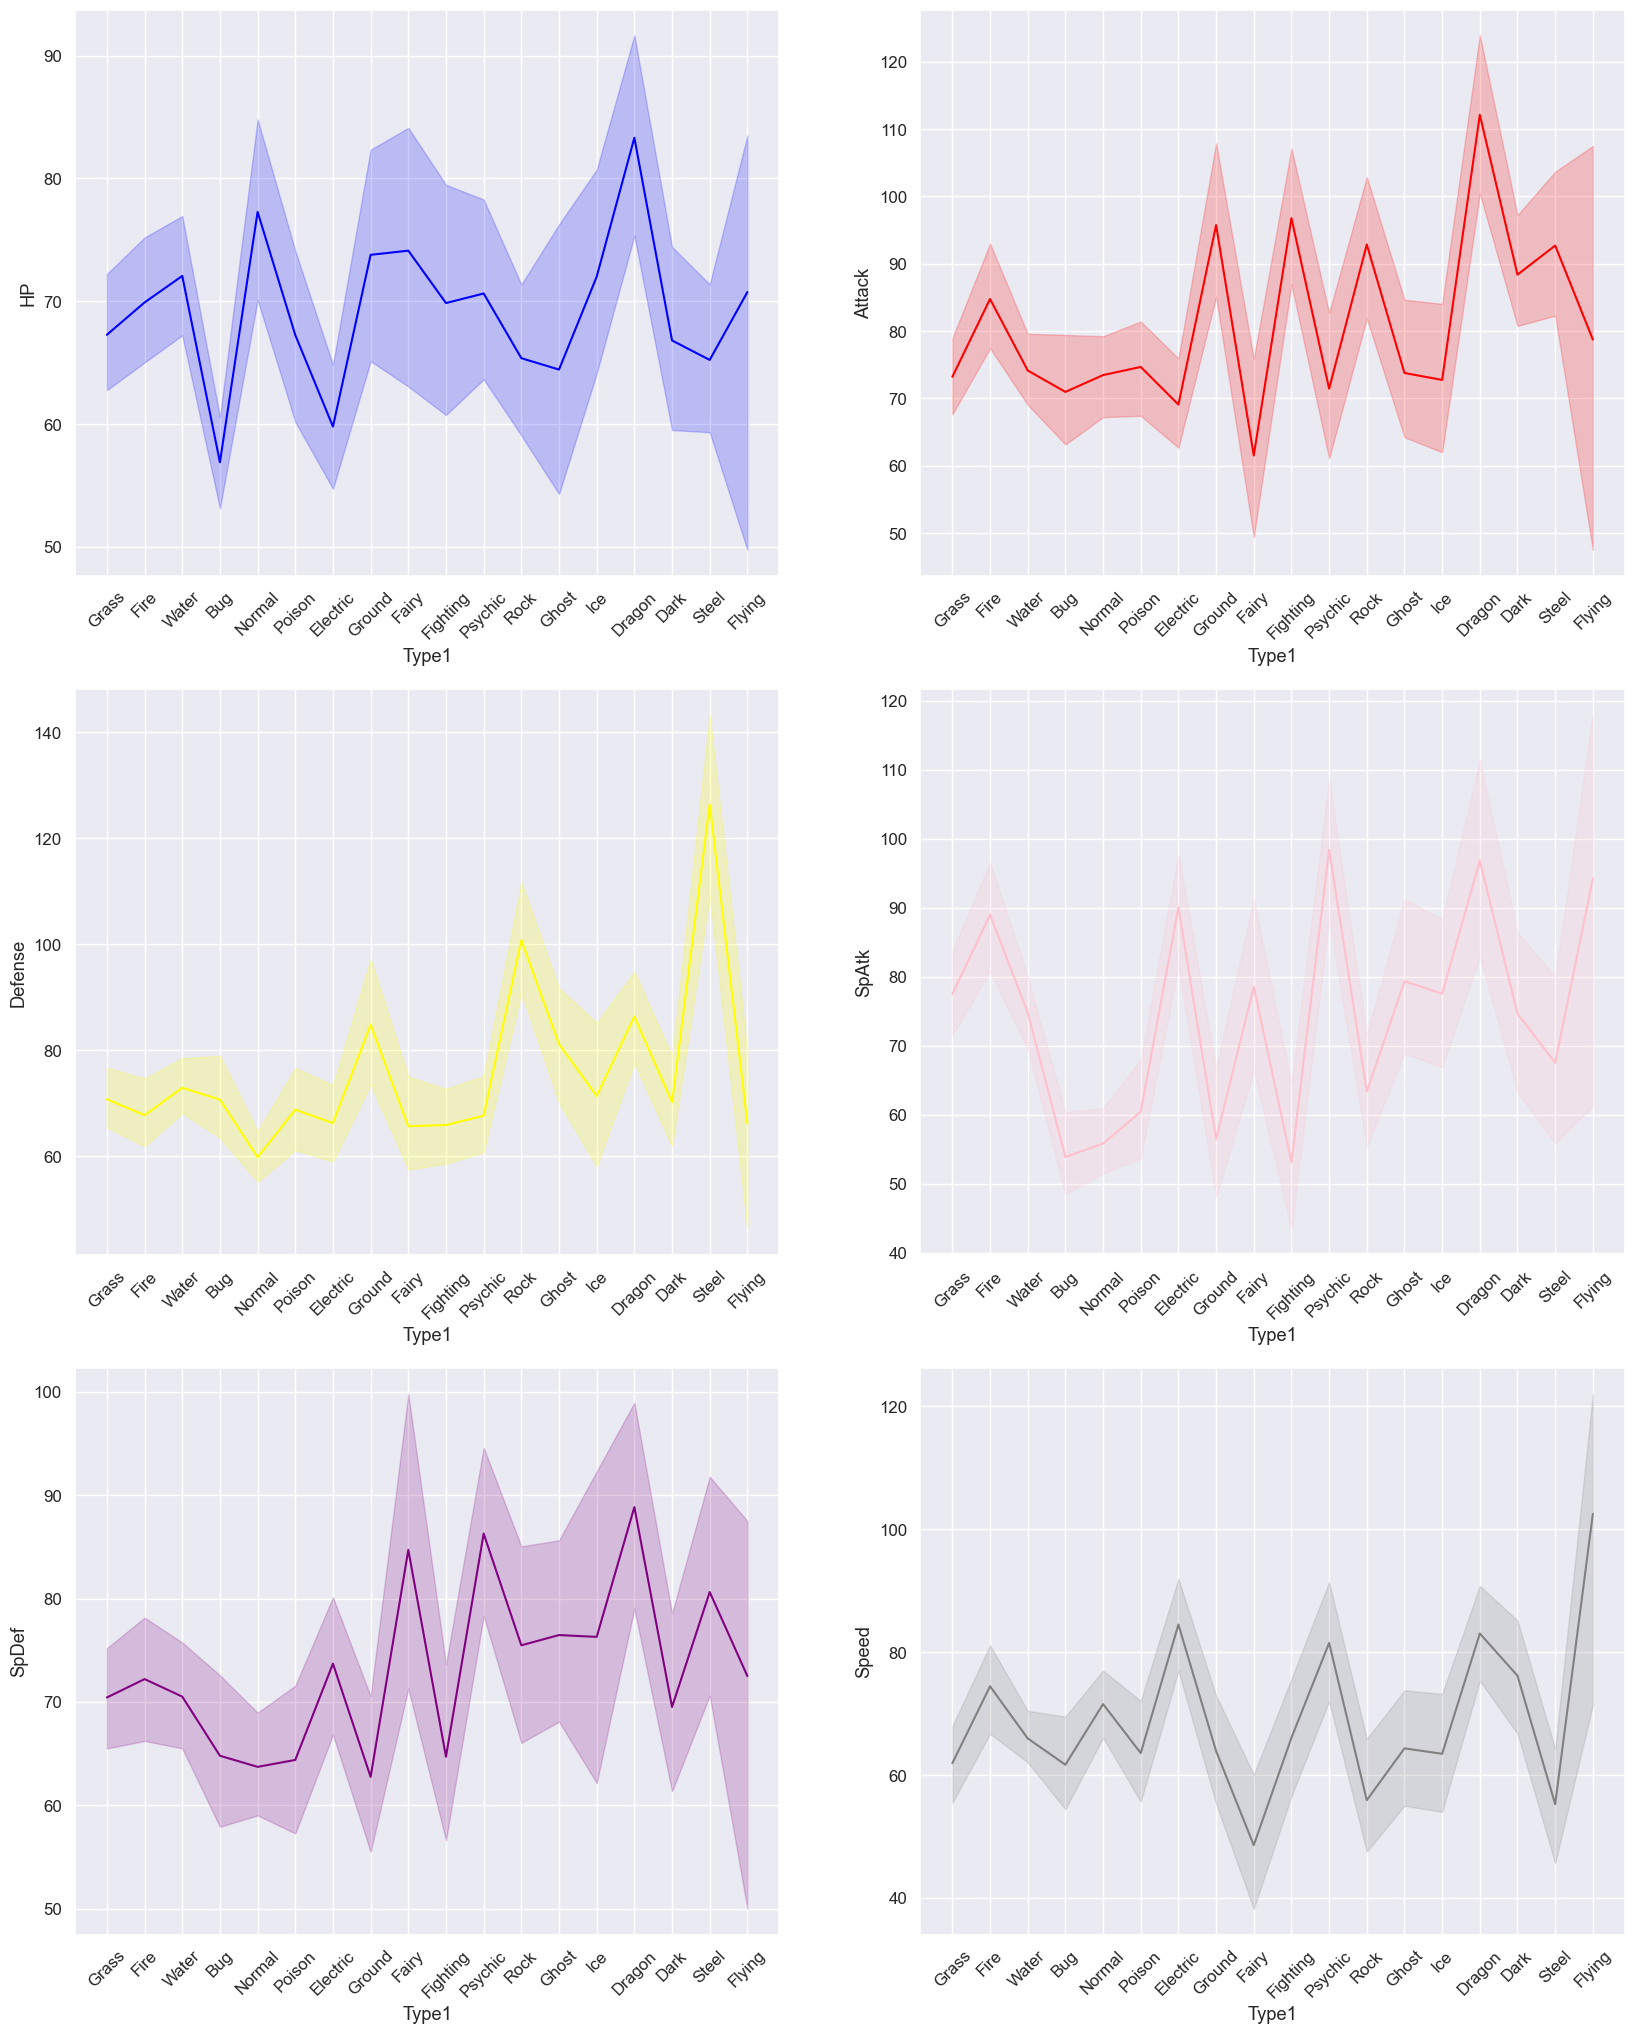

In [100]:
plt.figure(figsize = (20, 25))


plt.subplot(3,2,1)
sns.lineplot(x="Type1", y="HP", data=df,color='blue')
plt.xticks(rotation=45)

plt.subplot(3,2,2)
sns.lineplot(x="Type1", y="Attack", data=df, color='red')
plt.xticks(rotation=45)

plt.subplot(3,2,3)
sns.lineplot(x="Type1", y="Defense", data=df, color='yellow')
plt.xticks(rotation=45)

plt.subplot(3,2,4)
sns.lineplot(x="Type1", y="SpAtk", data=df, color='pink')
plt.xticks(rotation=45)

plt.subplot(3,2,5)
sns.lineplot(x="Type1", y="SpDef", data=df ,color='purple')
plt.xticks(rotation=45)

plt.subplot(3,2,6)
sns.lineplot(x="Type1", y="Speed", data=df ,color='grey')
plt.xticks(rotation=45)

Yukarıda çizdirmiş olduğumuz çizgi grafiklerde, Type1 bilgilerine göre saldırı, savunma gibi farklı değerlerin dağılımını görebiliyoruz.

Örneğin, görülebileceği üzere can (HP) değeri en yüksek pokemon türü Dragon'dır. Yine standart saldırı değeri (Attack) için de Dragon türünün en yüksek değere sahip olduğunu görebiliyoruz. Bunun yanısıra Dragon standart savunma değeri (Defense) için daha geride gözükse de, özel savunma değeri (SpDef) için yine hatrı sayılır bir puan değerine sahip görünmektedir. Dragon türündeki pokemonlar, her ne kadar  hız değeri puanlarında da düşüklük gösterseler de ortalamada oldukça güçlü bir profilde gözükmektedirler.

### Jenerasyon Kırılımındaki Bilgiler

In [101]:
df.groupby('Generation').agg({
    'HP':['mean', 'min', 'max'],
    'Attack':['mean', 'min', 'max'],
    'Defense':['mean', 'min', 'max'],
    'SpAtk':['mean', 'min', 'max'],
    'SpDef':['mean', 'min', 'max'],
    'Speed':['mean', 'min', 'max'],
    'Legendary':['count','sum']
}).sort_values(by=('Legendary', 'sum'), ascending = False)

HP              Attack             Defense           \
                 mean min  max       mean min  max       mean min  max   
Generation                                                               
Third       66.543750   1  170  81.625000  15  180  74.100000  20  230   
Fifth       71.787879  30  165  82.066667  25  170  72.327273  30  145   
Fourth      73.082645  20  150  82.867769   5  170  78.132231   5  168   
Sixth       68.268293  38  126  75.804878  22  160  76.682927  33  184   
First       65.819277  10  250  76.638554   5  190  70.861446   5  180   
Second      71.207547  20  255  72.028302  10  185  73.386792  10  230   

                SpAtk               SpDef               Speed           \
                 mean min  max       mean min  max       mean min  max   
Generation                                                               
Third       75.806250  10  180  71.225000  20  200  66.925000  10  180   
Fifth       71.987879  15  170  68.739394  25  135  68.078788  10  145   
Fourth      76.404959  10  150  77.190083  30  150  71.338843   5  135   
Sixth       74.292683  27  170  74.890244  25  154  66.439024  23  126   
First       71.819277  15  194  69.090361  20  130  72.584337  15  150   
Second      65.943396  10  165  73.905660  20  230  61.811321   5  130   

           Legendary      
               count sum  
Generation                
Third            160  18  
Fifth            165  15  
Fourth           121  13  
Sixth             82   8  
First            166   6  
Second           106   5

Yukarıda üretmiş olduğumuz tabloda, jenerasyon kırılımında özellik değerlerinin minimum, maksimum ve ortalama değerlerini görebiliyoruz. İlgili jenerasyonda kaç adet efsanevi pokemon olduğunu gösteren sütun için sum fonksiyonunu kullandık. Biliyoruz ki Legendary kolonu True ve False değerlerden oluşuyor ve bunların sayısal temsilleri 1 ve 0 şeklinde. O yüzden toplam sayı için count fonksiyonu kullanırken, sum ile True değerlerin toplamını elde edebilir ve kaç adet efsanevi pokemon olduğunu görebiliriz.

Jenerasyon bazlı olarak baktığımızda, efsanevi pokemonların en çok ilk jenerasyonda, en az ise son jenerasyonda bulunduğunu görebiliyoruz.

In [102]:
df_gen1 = df.groupby(['Generation', 'Type1']).agg({
    'HP':['mean', 'min', 'max'],
    'Attack':['mean', 'min', 'max'],
    'Defense':['mean', 'min', 'max'],
    'SpAtk':['mean', 'min', 'max'],
    'SpDef':['mean', 'min', 'max'],
    'Speed':['mean', 'min', 'max'],
    'Legendary':['count','sum']
})

df_gen1

HP               Attack              Defense      \
                          mean min  max        mean min  max        mean min   
Generation Type1                                                               
Fifth      Bug       59.111111  30   85   77.611111  40  135   78.277778  40   
           Dark      63.538462  40  110   81.384615  50  125   71.692308  37   
           Dragon    93.333333  46  125  129.000000  87  170   90.000000  60   
           Electric  64.750000  35   85   88.750000  55  115   60.625000  32   
           Fighting  81.428571  45  120  108.571429  80  140   72.142857  50   
...                        ...  ..  ...         ...  ..  ...         ...  ..   
Third      Poison    81.000000  70  100   72.000000  43  100   65.333333  53   
           Psychic   58.500000  28   95   70.666667  23  180   60.666667  20   
           Rock      65.250000  30   86   79.625000  41  125  101.125000  50   
           Steel     65.833333  40  100   98.750000  55  145  130.833333  80   
           Water     72.370370  20  170   80.666667  15  150   67.962963  20   

                              SpAtk               SpDef               Speed  \
                     max       mean min  max       mean min  max       mean   
Generation Type1                                                              
Fifth      Bug       125  62.888889  30  135  66.944444  35  105  71.277778   
           Dark      115  65.615385  35  125  65.538462  37  115  70.153846   
           Dragon    120  97.777778  30  170  83.333333  40  120  81.555556   
           Electric   80  87.500000  45  145  63.125000  32   80  82.125000   
           Fighting   95  47.142857  25   95  60.000000  35   85  60.000000   
...                  ...        ...  ..  ...        ...  ..  ...        ...   
Third      Poison     83  72.000000  43  100  65.333333  53   83  53.333333   
           Psychic   160  97.750000  23  180  81.500000  20  160  89.000000   
           Rock      200  62.125000  40   95  83.000000  50  107  50.750000   
           Steel     230  65.416667  35  105  80.833333  40  150  56.666667   
           Water     130  78.481481  10  180  68.962963  20  160  64.592593   

                             Legendary      
                    min  max     count sum  
Generation Type1                            
Fifth      Bug       20  145        18   0  
           Dark      38  106        13   0  
           Dragon    48   97         9   5  
           Electric  40  116         8   2  
           Fighting  35  105         7   0  
...                  ..  ...       ...  ..  
Third      Poison    40   65         3   0  
           Psychic   23  180        12   4  
           Rock      23   75         8   1  
           Steel     30  110        12   2  
           Water     30  105        27   2  

[98 rows x 20 columns]

Yukarıda yazmış olduğumuz kod ile veriyi gruplarken bir seviye daha kırarak, kırılım detayına Type1'ı da ekledik. Bu sayede örneğin, aşağıda olduğu şekliyle, beşinci jenerasyona ait Elektrik türündeki pokemonların özellikleri için minimum, maksimum ve ortalama değerleri hızlıca görüntüleyebiliriz. Görüntülenecek istatistiksel özellikleri, oluşturmuş olduğumuz sözlük yapısını genişleterek arttırabiliriz.

In [103]:
df_gen1.loc[('Fifth', 'Electric')]

HP         mean      64.750
           min       35.000
           max       85.000
Attack     mean      88.750
           min       55.000
           max      115.000
Defense    mean      60.625
           min       32.000
           max       80.000
SpAtk      mean      87.500
           min       45.000
           max      145.000
SpDef      mean      63.125
           min       32.000
           max       80.000
Speed      mean      82.125
           min       40.000
           max      116.000
Legendary  count      8.000
           sum        2.000
Name: (Fifth, Electric), dtype: float64

Aşağıda oluşturmuş olduğumuz boxplot figürü için, öncelikle Total isimli yeni bir değişken oluşturuyoruz. Bu değişken, her Pokemon için özellik puanlarının toplam değerini içeriyor,  böylece özelliklerin toplamı üzerinden her bir pokemonun gücünü temsil eden tekil değerler üretmiş oluyoruz. 

Oluşturmuş olduğumuz bu değerleri, jenerasyon kırılımında boxplot'a verdiğimizde, jenerasyon bazlı olarak toplam güç değerlerini görebiliyoruz. Bu durumda ortalamada en güçlü jenerasyon dördüncü iken, en güçsüz olan ise ikinci jenerasyon olarak gözükmektedir. Güç değerlerinin en geniş dağılıma sahip olduğu jenerasyon ise ikinci jenerasyondur.

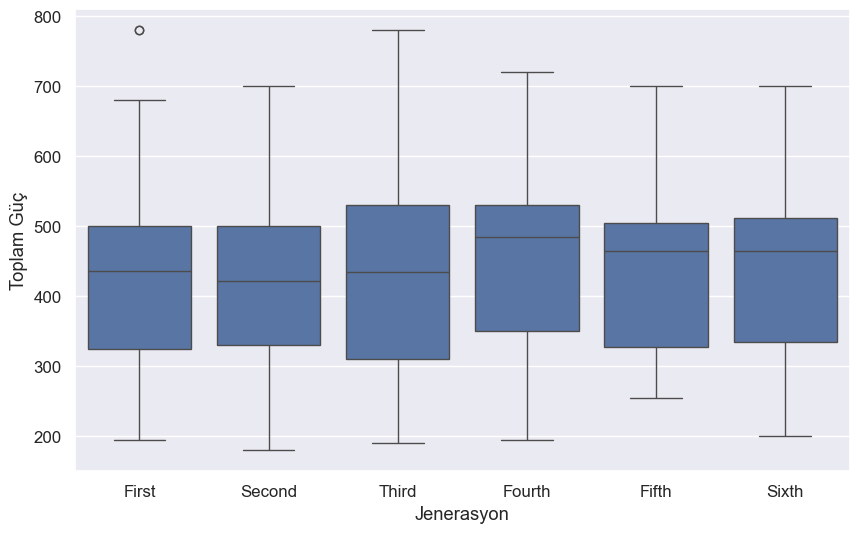

In [104]:
df['Total'] = df[['HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']].sum(axis=1)

plt.figure(figsize=(10,6))
sns.boxplot(data = df, x = 'Generation', y = 'Total')
plt.xlabel('Jenerasyon')
plt.ylabel('Toplam Güç')
plt.show()

In [105]:
df.head()

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary,Total
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,First,False,318
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,First,False,405
2,Venusaur,Grass,Poison,80,82,83,100,100,80,First,False,525
3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,First,False,625
4,Charmander,Fire,None,39,52,43,60,50,65,First,False,309


### Efsanevi Pokemonların Efsanevi Olmayanlar ile Karşılaştırılması

Aşağıda çizdirmiş olduğumuz boxplotlara baktığımızda, efsanevi ve efsanevi olmayan pokemonların özelliklerinin karşılaştırmasını yapabiliyoruz.

Görüldüğü üzere efsanevi pokemonlar, tüm özellikler için olmayanlara göre baskın bir durumda.

Grafiklerde görüldüğü üzere, aykırı değer olarak değerlendirilebilecek bir çok veri kaydı bulunmakta. Ancak biz veri setinin hikayesinden ve incelemesinden biliyoruz ki, her veri kaydı spesifik olarak bir pokemon türünü göstermekte ve her pokemonun da kendine has özellik puanları bulunmakta. Bu durumda, sayısal olarak aykırı gibi gözüken değerlerin manipüle edilmesi veya veri setinden kaldırılması veri setindeki benzersiz kayıtların silinmesine ve verinin kalitesinin bozulmasına sebep olacaktır. Bu durumdan ötürü, veride aykırı değerlere ilişkin herhangi bir işlem yapılmayacaktır.

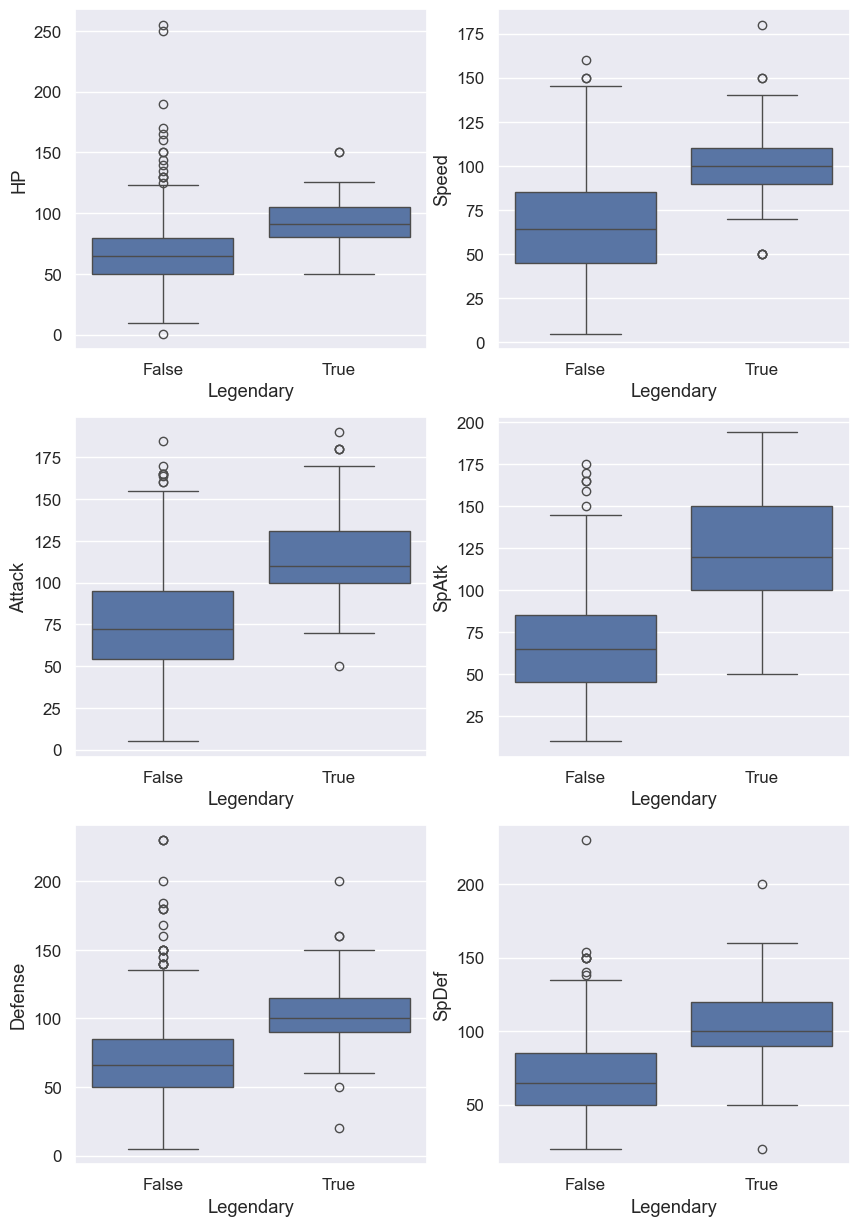

In [106]:
plt.figure(figsize = (10,15))

plt.subplot(3,2,1)
sns.boxplot(data = df, x = 'Legendary', y = 'HP')
plt.subplot(3,2,2)
sns.boxplot(data = df, x = 'Legendary', y = 'Speed')
plt.subplot(3,2,3)
sns.boxplot(data = df, x = 'Legendary', y = 'Attack')
plt.subplot(3,2,4)
sns.boxplot(data = df, x = 'Legendary', y = 'SpAtk')
plt.subplot(3,2,5)
sns.boxplot(data = df, x = 'Legendary', y = 'Defense')
plt.subplot(3,2,6)
sns.boxplot(data = df, x = 'Legendary', y = 'SpDef')


plt.show()

### Korelasyon Matrisi

Bildiğimiz üzere, Korelasyon Matrisi değişkenler arasındaki ilişkinin büyüklüğünü ifade eder. Bunu aşağıda olduğu gibi Seaborn kütüphanesinden çağırdığımız bir ısı haritası ile yapabiliriz.

Elde ettiğimiz matrise baktığımızda, en yüksek değerli ilişkilerin 0.51 olduğunu görüyoruz. Bu ilişki değerine sahip değişkenler Defense-SpDef ve SpAtk-SpDef. Ancak her ne kadar pozitif yönlü bir ilişki görüntülesek de 0.51 değeri üzerinde ekstra bir işlem yapmayı gerektirecek kadar büyük bir değer değil.

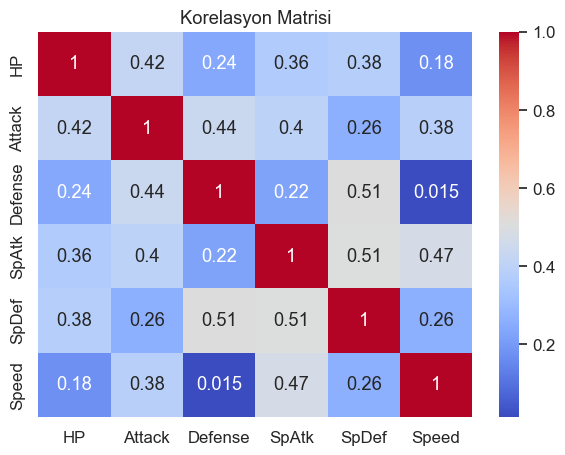

In [107]:
plt.figure(figsize = (7,5))
sns.heatmap(df[['HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', 'Speed']].corr(), annot = True, cmap = 'coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()


# 3. BONUS: Makine Öğrenmesi Modeli (Sınıflama)

Bu bölümde elimizdeki veriye farklı sınıflama modelleri ve parametreler uygulayarak yeni eklenecek bir Pokemon'un Efsanevi olup olmayacağını tahminlemeye çalışacağız.

Bunun için ilk olarak, Keşifsel Veri Analizi bölümünde eklemiş olduğumuz Total isimli değişkenini veri setinden çıkartıyoruz.

In [108]:
df = df.drop(columns = ['Total']); df.head()

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,45,49,49,65,65,45,First,False
1,Ivysaur,Grass,Poison,60,62,63,80,80,60,First,False
2,Venusaur,Grass,Poison,80,82,83,100,100,80,First,False
3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,First,False
4,Charmander,Fire,None,39,52,43,60,50,65,First,False


İkinci olarak, aşağıdaki işlemler ile veri setini hedef değişken ve featureları içerecek şekilde x ve y veri setlerine ayırıyoruz. Hedef değişkenimiz Legendary kolonu olacağı için, modellerde bu kolondaki True ve False değerleri 1 ve 0 görebilmesi için verinin tipini kategorik olarak değiştirmemiz gerekiyor.

In [109]:
df = df.drop(columns = ['Name']); df.head()

,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,Grass,Poison,45,49,49,65,65,45,First,False
1,Grass,Poison,60,62,63,80,80,60,First,False
2,Grass,Poison,80,82,83,100,100,80,First,False
3,Grass,Poison,80,100,123,122,120,80,First,False
4,Fire,None,39,52,43,60,50,65,First,False


In [110]:
y = df['Legendary'].astype('category')
x = df.drop(columns = ['Legendary'])

In [111]:
x.head()

,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation
0,Grass,Poison,45,49,49,65,65,45,First
1,Grass,Poison,60,62,63,80,80,60,First
2,Grass,Poison,80,82,83,100,100,80,First
3,Grass,Poison,80,100,123,122,120,80,First
4,Fire,None,39,52,43,60,50,65,First


In [112]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: category
Categories (2, bool): [False, True]

Elimizdeki tip bilgileri numerik olmadığı için, sınıflama modeline sokmak için uygun olmayacak. Ancak Pandas'ın get_dummies() fonksiyonunu kullanarak numerik olmayan bu değişkenleri True/False (1/0) tipini değiştirecek şekilde kolonlara bölebiliriz. 

In [113]:
x = pd.get_dummies(x, columns = ['Type1', 'Type2', 'Generation'], drop_first=True); x.head()

,HP,Attack,Defense,SpAtk,SpDef,Speed,Type1_Dark,Type1_Dragon,Type1_Electric,Type1_Fairy,...,Type2_Poison,Type2_Psychic,Type2_Rock,Type2_Steel,Type2_Water,Generation_First,Generation_Fourth,Generation_Second,Generation_Sixth,Generation_Third
0,45,49,49,65,65,45,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,60,62,63,80,80,60,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
2,80,82,83,100,100,80,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,80,100,123,122,120,80,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
4,39,52,43,60,50,65,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


Veri setini eğitebilmemiz için train ve test set olmak üzere ikiye bölüyoruz. Sınıfladırma modeli yapacağımıız için elimizdeki verilerin tabakalı bir şekilde train ve test set'e dağıtılabilmesi için (yani hedef değişken homojenliğinin korunabilmesi için) stratify parametresini hedef değişkenimize (y) göre ayarlıyoruz. %80/%20'lik bir train/test oranı oluşturmak istediğimiz için test_size parametresine 0.2 değerini veriyoruz. Benimle aynı sonuçları değerlendirebilmek için random_state parametresini 10 olarak kullanabilirsiniz.

In [114]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10, stratify = y)

Ben bu çalışmada 4 farklı sınıflandırma modelini kullanmayı tercih ettim:

* Logistic Regression
* K-Neighbor Classifier
* Random Forest Classifier
* Gradient Boosting Classifier

Bu sınıflama modellerini farklı parametre değerleriyle hızlı bir şekilde deneyebilmek için GridSearchCV'yi kullanabiliriz.

Aşağıdaki kodda öncelikle bir pipeline oluşturduk. Bu pipeline içine gönderdiğimiz veri setini öncelikle ölçekleyecek (her kolonu ortalaması 0, standart sapması 1 olacak şekilde bir ölçeğin içine sıkıştıracak, böylece modelin çalışması biraz daha kolay olacak ve daha isabetli sonuçlar elde edebileceğiz), sonrasında ise sırasıyla belirlediğimiz modelleri deneyeceğiz. İlk başta pipeline kurmak için oluşturduğumuz pipe nesnesinin içerisine hangi yöntemi koyduğunuzun bir önemi yok. Zira belirlenen metodların hepsi tek tek deneniyor olacak zaten. pipe nesnesinin içerisine koyduğumuz metod sadece bir initializer görevi görüyor.

İkinci olarak bir search_space listesi oluşturarak, tam olarak aşağıda belirtildiği formatta sözlüklerle dolduruyoruz. Bu sözlükler görülebileceği üzere çalıştırılmak istenen sınıflama modellerini ve bu modellerde hangi parametrelerin denenmesinin istendiğinin bilgilerini içeriyor.

Devamında bir grid search nesnesi oluşturarak sırasıyla pipeline'ı, arama uzayımızı yolluyor, 5 split atacak şekilde StratifiedFold yaparak Cross Validation  yapmasını söylüyor ve skorlama metodu olarak sınıflama modeli çalıştırdığımız için accuracy, yani isabetlilik seçiyoruz. Daha sonrasında train setlerimizi modele vererek bizim için arama yapmasını bekliyoruz.

In [115]:
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])

search_space = [
    #Logistic Regression
    {
      'classifier':[LogisticRegression(max_iter=1000, solver='liblinear')],
      'classifier__C':np.logspace(-4, 4, 100),
      'classifier__penalty':['l1', 'l2']
    },
    #K-Neighbor Classifier
    {
      'classifier':[KNeighborsClassifier()],
      'classifier__n_neighbors':np.arange(1, 10)
    },
    #Random Forest Classifier
    {
      'classifier':[RandomForestClassifier()],
      'classifier__n_estimators':[100, 200, 300, 400, 500]
    },
    #Gradient Boosting Classifier
    {
      'classifier':[GradientBoostingClassifier()],
      'classifier__n_estimators':[100, 500, 1000],
      'classifier__learning_rate':[0.001, 0.01, 0.1]
    },
]

grid_search_cv = GridSearchCV(pipe, search_space, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10), verbose=0, scoring='accuracy')

best_model = grid_search_cv.fit(x_train, y_train)

best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'friedman_mse',
 'classifier__init': None,
 'classifier__learning_rate': 0.01,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 1000,
 'classifier__n_iter_no_change': None,
 'classifier__random_state': None,
 'classifier__subsample': 1.0,
 'classifier__tol': 0.0001,
 'classifier__validation_fraction': 0.1,
 'cl

Modelimiz gerekli denemeleri yaparak bize en uygun sınıflama modeli ve parametrelerinin GradientBoostingClassifier(n_estimators=100, learning_rate=0.1) şeklinde olduğunu belirtti. Şimdi modelimizi son bir kez tekrar train ederek test setimizdeki performansına bakacağız.

In [116]:
gbg = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01)
gbg.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000)

In [117]:
predicts = gbg.predict(x_test)

Görüleceği üzere Accuracy %95 şeklinde gözüküyor, ancak bu bizim yeterli olmamalı.

In [118]:
score_me(y_test, predicts)

Accuracy:  0.95
Precision:  0.7777777777777778
Recall:  0.5384615384615384


Farklı skorlara aşağıdaki sınıflama raporuyla da bakabiliriz. f1 score da oldukça fazla kullanılan bir skorlama tipidir. Nitekim bu noktada dikkatimizi çeken şey, 1.0 (yani legendary değer için yapılan tahminler) değeri için skorumuz aslında o kadar da yüksek değil. Şimdi gelin bunun için confusion matrix'e bakalım.

In [119]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       147
         1.0       0.78      0.54      0.64        13

    accuracy                           0.95       160
   macro avg       0.87      0.76      0.80       160
weighted avg       0.95      0.95      0.95       160



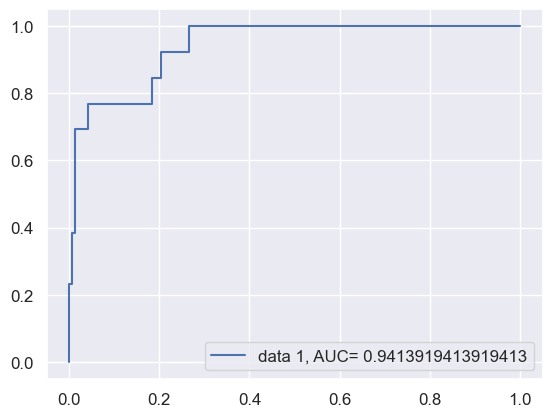

In [120]:
predicts_proba = gbg.predict_proba(x_test)
predicts_proba_one = predicts_proba[:,1]
plot_roc_curve(y_test, predicts_proba_one)

Aşağıda çizdirmiş olduğumuz confusion matrix'e baktığımızda, modelimizin çoğunlukla doğru tahmin yaptığını görebiliyoruz. Ancak Efsanevi pokemonlardan sadece 6 tanesini doğru bilmiş, 7 tanesini ise yanlış sınıflandırmış. Bu sonuç bizi tatmin etmemeli zira bizim modelimizin amacı efsanevi pokemonları tahmin edebiliyor olmaktı.

Elimizdeki pokemon verisinde, türlerin de önemli olabileceğini göz önünde bulundurarak eğitimde kullanacağımız veri setini ona göre ayarladık. Ancak türler Type1 ve Type2 olarak ayrışmış durumdaydı, yani bir pokemonun iki türünü de ifade eden konsolide bir özellik kolonuna sahip değildik. Bu durum dummies olarak oluşturulan tür bilgilerinin kolon sayılarını çok fazla arttırmasına sebep oldu.

Tür bilgisinin modelimiz için ne kadar önemli olup olmadığını değerlendirebilmek için modelin featurelara verdiği katsayılara göz atabiliriz. Eğer bulduğu sonuçta etkin olmayan kolonlar var ise bunlara bir göz atıp, tür bilgilerini modelimizden çıkartarak sadece özellik bilgilerine göre bir model kurabiliriz. Zira unutmayalım ki daha önce çizdirdiğimiz boxplotlar vasıtasıyla biz aslında özellik değerlerinin legendary pokemonlarda olmayanlara göre daha yüksek olduğunu gözlemlemiştik. Çıkarttığımız kolonlar ile tekrardan bir model kurmayı deneyebiliriz.

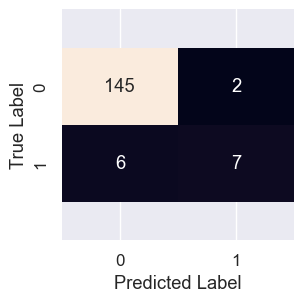

In [121]:
plot_conf_matrix(y_test, predicts)

### Feature Importance

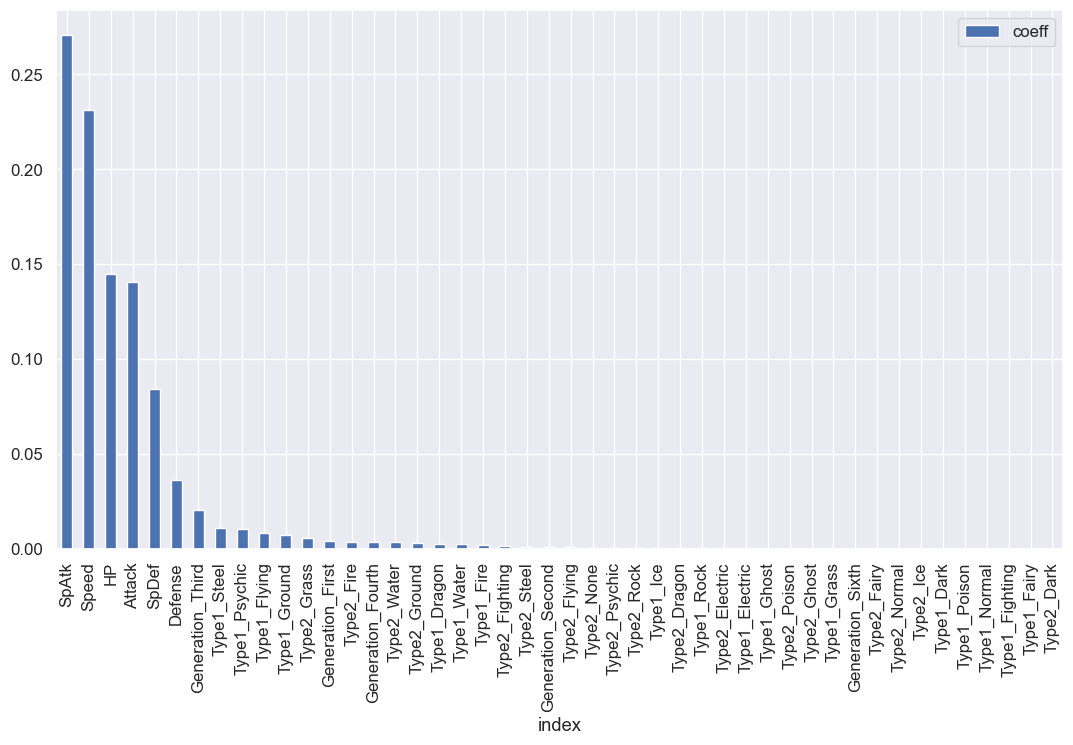

In [122]:
feature_dict = dict(zip(x.columns, list(gbg.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df = feature_df.T.reset_index()
feature_df.columns = ['index', 'coeff']
feature_df.sort_values(by = 'coeff', ascending = False).plot(kind = 'bar', x = 'index', y = 'coeff', figsize = (13,7))
plt.show()

Yukarıda çizdirmiş olduğumuz grafikte görülebileceği üzere, dummy olarak oluşturulan birçok kolon aslında modelde kullanılmamış bile. Type1 ve Type2 kolonlarından türetilen bazı değerler kullanılmış olsa da, görece olarak özellikler ile karşılaştırılamaz bile. Aynı şeyi Generation kolonu için de söylemek mümkün, o yüzden tercihen onu da çıkartıp tekrardan bir model kurmaya karar verelim.

## Sınıflama Modeli: 2. Round!

In [123]:
df = df_.copy()

In [124]:
df.head()

,Num,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [125]:
df = df.drop(columns = ['Num', 'Name', 'Type1', 'Type2', 'Generation']); df.head()

,HP,Attack,Defense,SpAtk,SpDef,Speed,Legendary
0,45,49,49,65,65,45,False
1,60,62,63,80,80,60,False
2,80,82,83,100,100,80,False
3,80,100,123,122,120,80,False
4,39,52,43,60,50,65,False


In [126]:
y = df['Legendary'].astype('category')
x = df.drop(columns = ['Legendary'])

In [127]:
y.head()

0    False
1    False
2    False
3    False
4    False
Name: Legendary, dtype: category
Categories (2, bool): [False, True]

In [128]:
x.head()

,HP,Attack,Defense,SpAtk,SpDef,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65


In [129]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10, stratify = y)

pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])

search_space = [
    #Logistic Regression
    {
      'classifier':[LogisticRegression(max_iter=1000, solver='liblinear')],
      'classifier__C':np.logspace(-4, 4, 100),
      'classifier__penalty':['l1', 'l2']
    },
    #K-Neighbor Classifier
    {
      'classifier':[KNeighborsClassifier()],
      'classifier__n_neighbors':np.arange(1, 10)
    },
    #Random Forest Classifier
    {
      'classifier':[RandomForestClassifier()],
      'classifier__n_estimators':[100, 200, 300, 400, 500]
    },
    #Gradient Boosting Classifier
    {
      'classifier':[GradientBoostingClassifier()],
      'classifier__n_estimators':[100, 500, 1000],
      'classifier__learning_rate':[0.001, 0.01, 0.1]
    },
]

grid_search_cv = GridSearchCV(pipe, search_space, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10), verbose=0, scoring='accuracy')

best_model = grid_search_cv.fit(x_train, y_train)

best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier',
   GradientBoostingClassifier(learning_rate=0.01, n_estimators=500))],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': GradientBoostingClassifier(learning_rate=0.01, n_estimators=500),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__criterion': 'friedman_mse',
 'classifier__init': None,
 'classifier__learning_rate': 0.01,
 'classifier__loss': 'log_loss',
 'classifier__max_depth': 3,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__n_estimators': 500,
 'classifier__n_iter_no_change': None,
 'classifier__random_state': None,
 'classifier__subsample': 1.0,
 'classifier__tol': 0.0001,
 'classifier__validation_fraction': 0.1,
 'class

In [130]:
gbg = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500)
gbg.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=500)

In [131]:
predicts = gbg.predict(x_test)

In [132]:
score_me(y_test, predicts)

Accuracy:  0.95
Precision:  0.7777777777777778
Recall:  0.5384615384615384


In [133]:
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       147
         1.0       0.78      0.54      0.64        13

    accuracy                           0.95       160
   macro avg       0.87      0.76      0.80       160
weighted avg       0.95      0.95      0.95       160



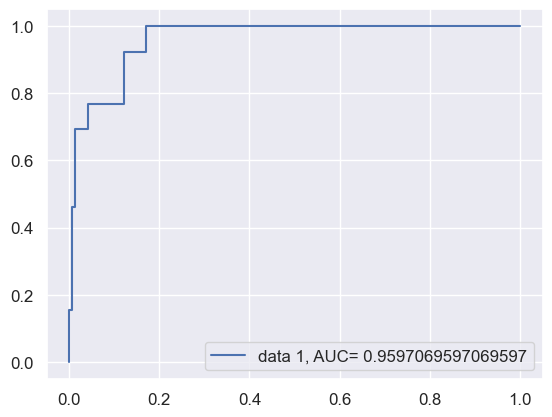

In [134]:
predicts_proba = gbg.predict_proba(x_test)
predicts_proba_one = predicts_proba[:,1]
plot_roc_curve(y_test, predicts_proba_one)

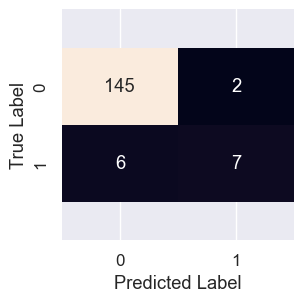

In [135]:
plot_conf_matrix(y_test, predicts)

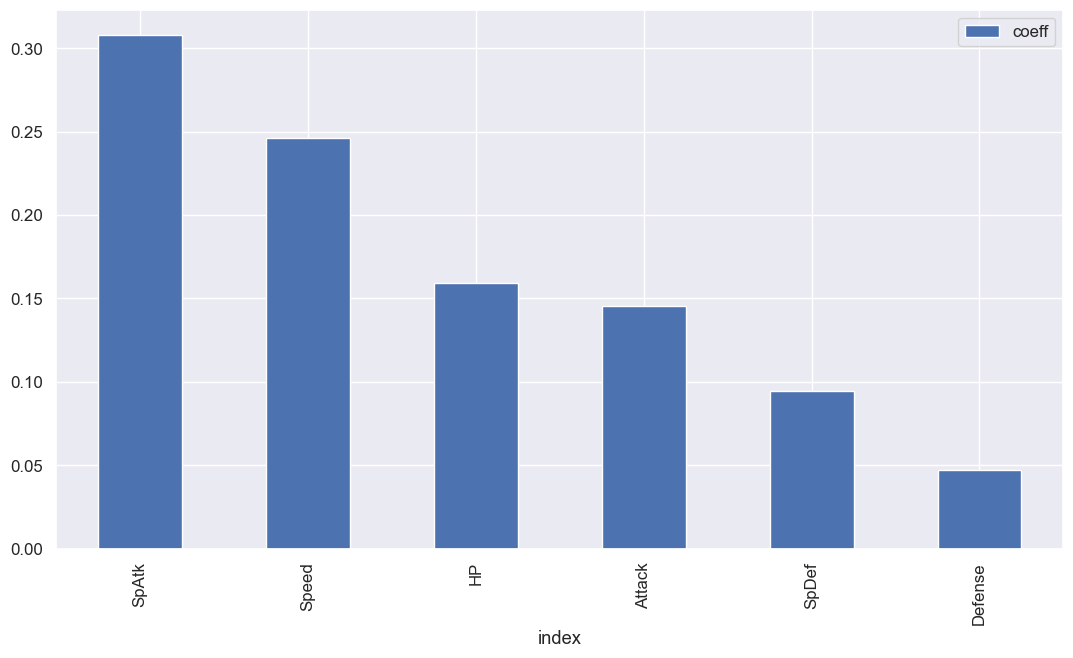

In [136]:
feature_dict = dict(zip(x.columns, list(gbg.feature_importances_)))
feature_df = pd.DataFrame(feature_dict, index = [0])
feature_df = feature_df.T.reset_index()
feature_df.columns = ['index', 'coeff']
feature_df.sort_values(by = 'coeff', ascending = False).plot(kind = 'bar', x = 'index', y = 'coeff', figsize = (13,7))
plt.show()

Kurmuş olduğumuz ikinci modelde görebileceğimiz üzere AUC score'da biraz iyileşme kazandık ancak modelimiz bir önceki modelde olduğu gibi legendary pokemonları yeterince iyi tahmin etmedi.

Bu noktada şu değerlendirmeyi yapmak da mümkün olacaktır, elimizdeki veri setinde efsanevi olan ve olmayan pokemonların sayısı arasında ciddi bir fark var. Bu dengesizlik muhtemelen modelin yeterince iyi çalışmıyor olmasına sebep olmaktadır. Bu çıkarımı  yapabiliyoruz çünkü efsanevi olmayan pokemonların değerlendirilmesinde (bkz. Classification Report) %97'lik bir f1 score elde ediyoruz, genel performansı ifade eden Accuracy Score ise %95. Yani modelimiz aslında çoğunlukla iyi performans gösteriyor, ancak legendary olanları ayırt etmek konusunda biraz kafası karışık :)

Bu durumda, mevcut veri setine 6. jenerasyondan sonra Pokemon evrenine dahil edilen diğer efsanevi pokemonlar da dahil edilebilirse modelimiz çok daha iyi bir performans gösterecektir. Mevcut durumda, son değerlendirmede GridSearch'ün bize önermiş olduğu Gradient Boosting Classifier (ilgili parametre değerleriyle) bize en iyi sonucu vermektedir.